In [1]:
# %load src/request_simulator.py
import random
from collections import namedtuple

import numpy as np
import simpy

LatencyDatum = namedtuple(
    'LatencyDatum',
    ('t_queued', 't_processing', 't_total')
)


class RequestSimulator(object):
    """ Simulates a M/G/k process common in request processing (computing)

    :param worker_desc: A tuple of (count, capacity) to construct workers with
    :param local_balancer: A function which takes the current request number
        and the list of workers and returns the index of the worker to send the
        next request to
    :param latency_fn: A function which takes the curent
        request number and the worker that was assigned by the load balancer
        amd returns the number of milliseconds a request took to process
    :param number_of_requests: The number of requests to run through the
        simulator
    :param request_per_s: The rate of requests per second.
    """

    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = []
        for i in range(count):
            worker = simpy.Resource(self.env, capacity=cap)
            worker.zone = "abc"[i % 3]
            self.workers.append(worker)
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            idx = self.load_balancer(i, self.workers)
            worker = self.workers[idx]
            response = self.process_request(
                i, worker,
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, request_id, worker):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
            t_start = self.env.now
            t_queued = t_start - t_arrive

            # Let the operation take w.e. amount of time the latency
            # function tells us to
            yield self.env.timeout(self.latency_fn(request_id, worker))

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = LatencyDatum(t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = RequestSimulator(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data


In [2]:
# %load src/lb_policies.py
import random

import numpy as np


def queue_size(resource):
    return resource.count + len(resource.queue)


def random_lb(request_num, workers):
    return random.randint(0, len(workers) - 1)


def rr_lb(request_num, workers):
    return request_num % len(workers)


def choice_two_lb(request_num, workers):
    r1, r2 = np.random.choice(range(len(workers)), 2, replace=False)
    r1 = random_lb(request_num, workers)
    r2 = random_lb(request_num, workers)
    if queue_size(workers[r1]) < queue_size(workers[r2]):
        return r1
    return r2


def _zone(request):
    return "abc"[request % 3]

def choice_n_weighted(n):
    def lb(request_num, workers):
        choices = np.random.choice(range(len(workers)), n, replace=False)
        result = []
        for idx, w in enumerate(choices):
            weight = 1.0;
            if _zone(request_num) == workers[w].zone:
                weight *= 1.0
            else:
                weight *= 4.0
            result.append((w, weight * (1 + queue_size(workers[w]))))

        result = sorted(result, key=lambda x:x[1])
        return result[0][0]
    return lb

def choice_two_adjacent_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    if r1 + 2 >= len(workers):
        r2 = r1 - 1
        r3 = r1 - 2
    else:
        r2 = r1 + 1
        r3 = r1 + 2

    iq = [(queue_size(workers[i]), i) for i in (r1, r2, r3)]
    return (sorted(iq)[0][1])


def shortest_queue_lb(request_num, workers):
    idx = 0
    for i in range(len(workers)):
        if queue_size(workers[i]) < queue_size(workers[idx]):
            idx = i
    return idx


In [3]:
# %load src/latency_distributions.py
import random

import numpy as np

def zone(request):
    return "abc"[request % 3]

def service(mean, slow, shape, slow_freq, slow_count):
    scale = mean - mean / shape
    scale_slow = slow - slow / shape

    def latency(request, worker):
        base = ((np.random.pareto(shape) + 1) * scale)
        if (zone(request) != worker.zone):
            base += 0.8
        if (request % slow_freq) < slow_count:
            add_l = ((np.random.pareto(shape) + 1) * scale_slow)
        else:
            add_l = 0
        return base + add_l
    return latency

def pareto(mean, shape):
    # mean = scale * shape / (shape - 1)
    # solve for scale given mean and shape (aka skew)
    scale = mean - mean / shape

    def latency(request, worker):
        return ((np.random.pareto(shape) + 1) * scale)
    return latency


def expon(mean):
    def latency(request, worker):
        return random.expovariate(1.0 / mean)
    return latency


In [4]:
# Simulate the various choices
NUM_REQUESTS = 60000
QPS = 10000
AVG_RESPONSE_MS = 0.4
SERVERS = 16

Simulation of M/G/k queues
======================

Now we look at M/G/k queues over multiple different load balancing choices.

We explore:
* Join Shorted Queue (JSK): The request is dispatched to the shortest queue
* M/G/k (MGk): A single queue is maintained and workers take requests as they are free
* Choice of two (choice_two): Two random workers are chosen, and then the request goes to the shorter queue
* Weighted Choice of N: A Random N workers are chosen and local zone nodes are 4x weighted non local zone nodes, then the least loaded is chosen.
* Random (random): A random queue is chosen
* Round-robin (roundrobin): The requests are dispatched to one queue after the other


In [5]:
lb_algos = {
    'choice-of-two': choice_two_lb,
    'random': random_lb,
    'round-robin': rr_lb,
    'shortest-queue': shortest_queue_lb,
    'weighted-choice-8': choice_n_weighted(8),
}

# Every 1000 requests have 10 that are slow (simulating a GC pause)
latency = service(mean=AVG_RESPONSE_MS, slow=20, shape=2, slow_freq=1000, slow_count=10)

lbs = {
    k : [i[2] for i in run_simulation((SERVERS, 1), v, NUM_REQUESTS, QPS, latency)]
    for (k, v) in lb_algos.items()
}
lbs['MGk'] = [
    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, latency)]

#lbs['join-idle'] = [
#    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS,
#                                 lambda request: 0.1 + pareto(AVG_RESPONSE_MS, 2)(request))
#]

types = sorted(lbs.keys(), key=lambda x: np.mean(lbs[x]))

hdr = "{0:20} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
print("-"*len(hdr))
for lb in types:
    mean = np.mean(lbs[lb])
    var = np.var(lbs[lb])
    percentiles = np.percentile(lbs[lb], [50, 95, 99, 99.9])
    print ("{0:20} | {1:7.1f} | {2:7.1f} | {3:7.1f} | {4:7.1f} | {5:>7.1f} | {6:7.1f} |".format(
        lb, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

Strategy             |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
---------------------------------------------------------------------------------
weighted-choice-8    |     1.1 |    33.3 |     0.3 |     2.1 |    18.5 |    66.7 |
MGk                  |     1.7 |     8.3 |     1.1 |     4.9 |    11.0 |    33.4 |
shortest-queue       |     1.9 |    21.7 |     1.1 |     4.5 |    18.4 |    67.8 |
choice-of-two        |     3.6 |   654.5 |     1.3 |    11.7 |    37.5 |   161.5 |
round-robin          |     5.6 |   162.4 |     1.1 |    25.6 |    66.0 |   129.7 |
random               |    10.7 |   647.9 |     2.1 |    49.5 |   133.7 |   270.0 |


In [6]:
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.style as style

font = {
    'size': 16
}

matplotlib.rc('font', **font)
style.use('seaborn-pastel')

def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)  

flier = dict(markerfacecolor='r', marker='.')

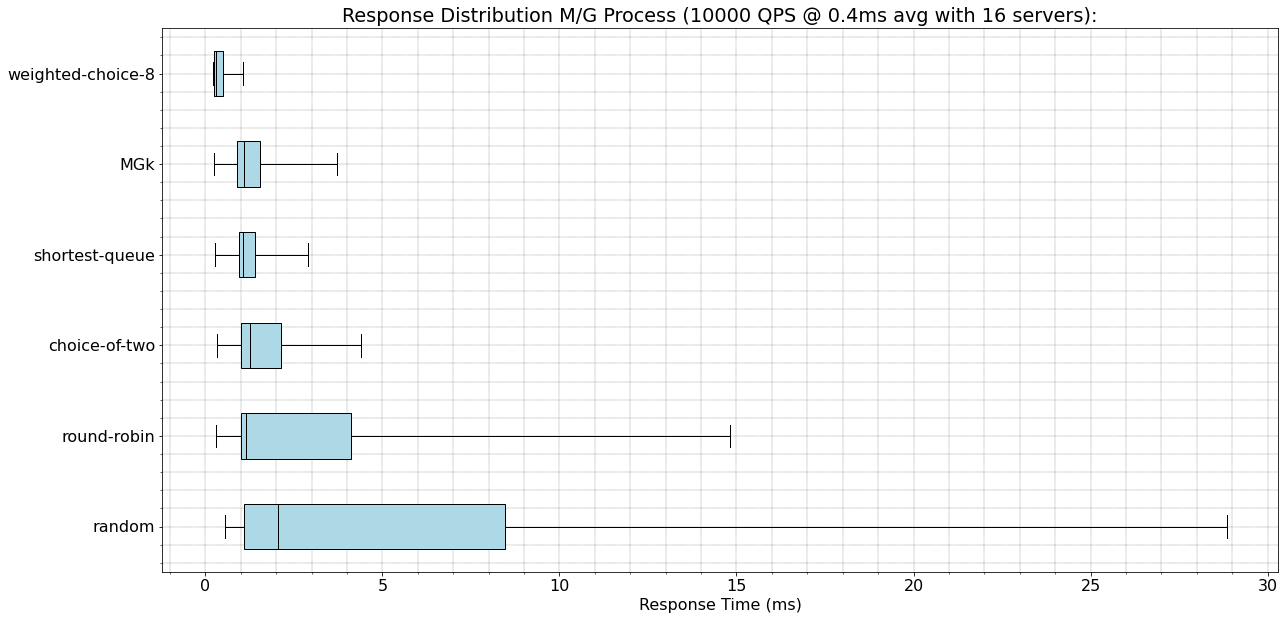

In [7]:
fig1, ax = plt.subplots(figsize=(20,10))
diamond = dict(markerfacecolor='r', marker='D')

types = list(reversed(types))
data = [lbs[i] for i in types]
bplot1 = ax.boxplot(data, whis=[10,90],showfliers=False,flierprops=flier, labels=types,
                    patch_artist=True, vert=False)
color_bplot(bplot1, 'black', 'lightblue')

plt.title('Response Distribution M/G Process ({0} QPS @ {1}ms avg with {2} servers):'.format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)
plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.xlabel('Response Time (ms)')
plt.show()